In [1]:
from pathlib import Path
from numpy import array
from tensorflow import squeeze
from tensorflow.image import crop_and_resize
from tensorflow.io import decode_png, read_file

generator_glob = Path().glob('datasets/**/*.png')
ndarray_png = array(
    [
        squeeze(
            crop_and_resize((decode_png(read_file(str(path)), 1),), ((.21, .48, .85, .71),), (0,), (300, 300))
        ) for path in generator_glob
    ]
)
ndarray_png.shape

2025-09-21 04:44:10.932371: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758429851.104483      27 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758429851.165354      27 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758429851.691206      27 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758429851.691243      27 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758429851.691245      27 computation_placer.cc:177] computation placer alr

(899, 300, 300)

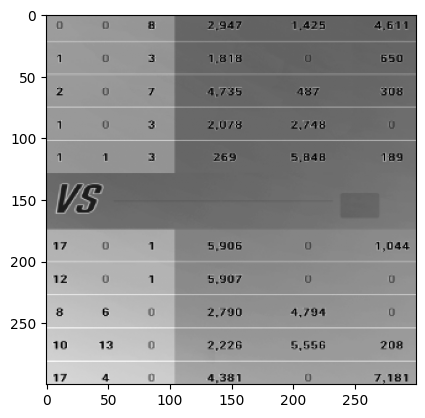

In [2]:
from matplotlib.pyplot import imshow, show

imshow(ndarray_png[0], 'binary')
show()

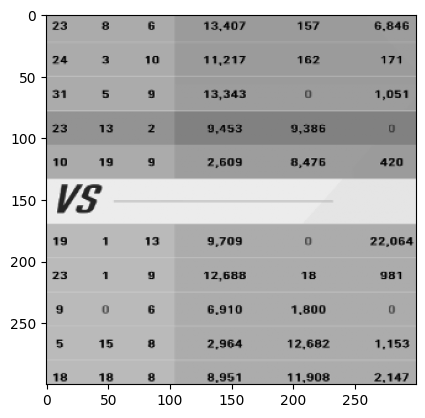

In [3]:
imshow(ndarray_png[-1], 'binary')
show()

In [4]:
import pandas as pd
from pandas import read_csv

index_col = 0
usecols = 0, 2, 3, 4, 5, 6, 7
frame_csv = pd.concat(
    (
        read_csv('datasets/role_defeat.csv', index_col=index_col, usecols=usecols),
        read_csv('datasets/role_draw.csv', index_col=index_col, usecols=usecols),
        read_csv('datasets/role_victory.csv', index_col=index_col, usecols=usecols)
    ),
    keys=['defeat', 'draw', 'victory']
)
ndarray_csv = frame_csv.values.reshape(-1, 60)
ndarray_csv[:2]

array([[    0,     0,     8,  2947,  1425,  4611,     1,     0,     3,
         1818,     0,   650,     2,     0,     7,  4735,   487,   308,
            1,     0,     3,  2078,  2748,     0,     1,     1,     3,
          269,  5848,   189,    17,     4,     0,  4381,     0,  7181,
           17,     0,     1,  5906,     0,  1044,    12,     0,     1,
         5907,     0,     0,     8,     6,     0,  2790,  4794,     0,
           10,    13,     0,  2226,  5556,   208],
       [   23,     9,    10, 10899,   163,  5789,    22,     3,     4,
         7938,     0,   340,    21,     2,    11, 11522,  1304,   231,
            0,    28,    10,    60, 11726,     0,    17,    14,     7,
         3894,  9805,   666,    26,    12,     8,  9395,     0,  6943,
           32,     3,     6, 10120,   248,  1281,    24,     1,     7,
         8344,     0,     0,    13,    14,     7,  3694,  8473,   316,
           18,    20,     7,  5677, 11922,   469]])

In [5]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Flatten, Dense, LeakyReLU, BatchNormalization

int_slice = -10
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)

In [6]:
from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X = X_scaler.fit_transform(ndarray_png.reshape(-1, 1)).reshape(-1, 300, 300)
y = y_scaler.fit_transform(ndarray_csv.reshape(-1, 6)).reshape(-1, 60)
X_train, y_train = X[:int_slice], y[:int_slice]
X_valid, y_valid = X[int_slice:], y[int_slice:]
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((889, 300, 300), (889, 60), (10, 300, 300), (10, 60))

In [7]:
clear_session()
model = Sequential()
model.add(Input((300, 300)))
model.add(Flatten())
model.add(Dense(300, 'relu'))
model.add(Dense(100, 'relu'))
model.add(Dense(60))
model.compile('adam', 'mean_squared_error', metrics=['root_mean_squared_error'])
history = model.fit(X_train, y_train, epochs=1000, callbacks=early_stopping_cb, validation_data=(X_valid, y_valid))
y_pred = y_scaler.inverse_transform(model.predict(X_valid).reshape(-1, 6)).reshape(-1, 10, 6).astype(int)
y_scaler.inverse_transform(y_valid.reshape(-1, 6)).reshape(-1, 10, 6).astype(int)[0], y_pred[0]

Epoch 1/1000


I0000 00:00:1758429890.307799      93 service.cc:152] XLA service 0x735994005880 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758429890.307847      93 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-09-21 04:44:50.375826: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1758429890.532789      93 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-09-21 04:44:51.311739: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_167_0', 120 bytes spill stores, 120 bytes spill loads

2025-09-21 04:44:51.311923: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot

13/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 94.1812 - root_mean_squared_error: 9.1831  

I0000 00:00:1758429894.028241      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 63.6078 - root_mean_squared_error: 7.4828

2025-09-21 04:44:55.007862: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_167_0', 120 bytes spill stores, 120 bytes spill loads

2025-09-21 04:44:55.206966: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_167', 540 bytes spill stores, 540 bytes spill loads

2025-09-21 04:44:55.394475: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_167', 200 bytes spill stores, 200 bytes spill loads

2025-09-21 04:44:55.431394: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_174', 4 bytes spill stores, 4 bytes spill loads

2025-09-21 04:44:55.727268: I external

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 62.2280 - root_mean_squared_error: 7.3940

2025-09-21 04:44:58.223576: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_25', 112 bytes spill stores, 112 bytes spill loads

2025-09-21 04:44:58.766246: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_25', 820 bytes spill stores, 864 bytes spill loads



28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 208ms/step - loss: 60.9434 - root_mean_squared_error: 7.3114 - val_loss: 0.0785 - val_root_mean_squared_error: 0.2801
Epoch 2/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0645 - root_mean_squared_error: 0.2539 - val_loss: 0.0775 - val_root_mean_squared_error: 0.2784
Epoch 3/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0822 - root_mean_squared_error: 0.2855 - val_loss: 0.0826 - val_root_mean_squared_error: 0.2874
Epoch 4/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0668 - root_mean_squared_error: 0.2580 - val_loss: 0.0748 - val_root_mean_squared_error: 0.2735
Epoch 5/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0606 - root_mean_squared_error: 0.2461 - val_loss: 0.0731 - val_root_mean_squared_error: 0.2705
Epoch 6/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0582 - root_mean_squared_error: 0.2412 - val_loss: 0.0714 - val_root_mean_squared_error: 0.2672
Epoch 7/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - l

(array([[   24,     2,     6, 12700,     0, 14797],
        [   25,     0,     3,  8648,   214,  1431],
        [   27,     9,     6,  9813,     0,     0],
        [    8,    20,     8,  2833,  7065,   120],
        [    3,    26,     6,  1106, 10446,     0],
        [   16,     4,     8,  9494,   856,  8806],
        [   14,     0,     9,  9440,   145,  2267],
        [   19,     5,     7,  8780,     0,     0],
        [    4,     7,    11,  1327,  5780,  1428],
        [    8,    14,     8,  3866,  8413,     0]]),
 array([[   18,     4,     6, 10107,   476,  9636],
        [   18,     1,     6,  8617,   173,   593],
        [   18,     2,     7,  9133,   350,   625],
        [   10,    14,     5,  3898,  8522,   655],
        [   10,    14,     5,  3650,  8757,   508],
        [   18,     4,     6,  9802,   635,  8695],
        [   17,     1,     7,  8881,   345,   614],
        [   17,     2,     7,  8773,   301,   542],
        [    9,    13,     5,  3490,  8966,   471],
        [ 

In [8]:
clear_session()
model = Sequential()
model.add(Input((300, 300)))
model.add(Flatten())
model.add(Dense(50, 'relu'))
model.add(Dense(50, 'relu'))
model.add(Dense(50, 'relu'))
model.add(Dense(60))
model.compile('adam', 'mean_squared_error', metrics=['root_mean_squared_error'])
history = model.fit(X_train, y_train, epochs=1000, callbacks=early_stopping_cb, validation_data=(X_valid, y_valid))
y_pred = y_scaler.inverse_transform(model.predict(X_valid).reshape(-1, 6)).reshape(-1, 10, 6).astype(int)
y_scaler.inverse_transform(y_valid.reshape(-1, 6)).reshape(-1, 10, 6).astype(int)[0], y_pred[0]

Epoch 1/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - loss: 3.1299 - root_mean_squared_error: 1.6494 - val_loss: 0.0744 - val_root_mean_squared_error: 0.2727
Epoch 2/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0576 - root_mean_squared_error: 0.2400 - val_loss: 0.0615 - val_root_mean_squared_error: 0.2480
Epoch 3/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0468 - root_mean_squared_error: 0.2160 - val_loss: 0.0408 - val_root_mean_squared_error: 0.2020
Epoch 4/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0299 - root_mean_squared_error: 0.1728 - val_loss: 0.0220 - val_root_mean_squared_error: 0.1482
Epoch 5/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0204 - root_mean_squared_error: 0.1428 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1214
Epoch 6/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0155 - root_mean_squared_error: 0.1246 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1151
Epoch 7/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/st

(array([[   24,     2,     6, 12700,     0, 14797],
        [   25,     0,     3,  8648,   214,  1431],
        [   27,     9,     6,  9813,     0,     0],
        [    8,    20,     8,  2833,  7065,   120],
        [    3,    26,     6,  1106, 10446,     0],
        [   16,     4,     8,  9494,   856,  8806],
        [   14,     0,     9,  9440,   145,  2267],
        [   19,     5,     7,  8780,     0,     0],
        [    4,     7,    11,  1327,  5780,  1428],
        [    8,    14,     8,  3866,  8413,     0]]),
 array([[   19,     4,     6, 10275,   450,  9744],
        [   18,     1,     5,  8820,   116,   618],
        [   18,     2,     6,  9435,   356,   646],
        [   10,    14,     5,  3908,  8758,   699],
        [   10,    14,     6,  3670,  8797,   493],
        [   16,     4,     6,  9838,   642,  9164],
        [   17,     1,     7,  9038,   351,   740],
        [   17,     2,     7,  7630,   295,   573],
        [    9,    14,     6,  3531,  8621,   502],
        [ 

In [9]:
clear_session()
model = Sequential()
model.add(Input((300, 300)))
model.add(Flatten())
model.add(Dense(30, 'relu'))
model.add(Dense(30, 'relu'))
model.add(Dense(60))
model.compile('adam', 'mean_squared_error', metrics=['root_mean_squared_error'])
history = model.fit(X_train, y_train, epochs=1000, callbacks=early_stopping_cb, validation_data=(X_valid, y_valid))
y_pred = y_scaler.inverse_transform(model.predict(X_valid).reshape(-1, 6)).reshape(-1, 10, 6).astype(int)
y_scaler.inverse_transform(y_valid.reshape(-1, 6)).reshape(-1, 10, 6).astype(int)[0], y_pred[0]

Epoch 1/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 23.3431 - root_mean_squared_error: 4.4711 - val_loss: 0.0772 - val_root_mean_squared_error: 0.2779
Epoch 2/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0622 - root_mean_squared_error: 0.2493 - val_loss: 0.0721 - val_root_mean_squared_error: 0.2684
Epoch 3/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0557 - root_mean_squared_error: 0.2359 - val_loss: 0.0638 - val_root_mean_squared_error: 0.2526
Epoch 4/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0494 - root_mean_squared_error: 0.2222 - val_loss: 0.0539 - val_root_mean_squared_error: 0.2321
Epoch 5/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0392 - root_mean_squared_error: 0.1980 - val_loss: 0.0435 - val_root_mean_squared_error: 0.2087
Epoch 6/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0333 - root_mean_squared_error: 0.1824 - val_loss: 0.0343 - val_root_mean_squared_error: 0.1852
Epoch 7/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/ste

(array([[   24,     2,     6, 12700,     0, 14797],
        [   25,     0,     3,  8648,   214,  1431],
        [   27,     9,     6,  9813,     0,     0],
        [    8,    20,     8,  2833,  7065,   120],
        [    3,    26,     6,  1106, 10446,     0],
        [   16,     4,     8,  9494,   856,  8806],
        [   14,     0,     9,  9440,   145,  2267],
        [   19,     5,     7,  8780,     0,     0],
        [    4,     7,    11,  1327,  5780,  1428],
        [    8,    14,     8,  3866,  8413,     0]]),
 array([[   18,     4,     6, 10151,   458,  9656],
        [   18,     1,     6,  8650,   174,   583],
        [   18,     2,     7,  9149,   348,   640],
        [   10,    14,     5,  3899,  8560,   645],
        [   10,    14,     5,  3669,  8779,   512],
        [   18,     4,     6,  9747,   641,  8705],
        [   17,     1,     7,  8909,   367,   592],
        [   17,     2,     7,  8796,   290,   506],
        [    9,    13,     6,  3498,  8994,   441],
        [ 

In [10]:
clear_session()
model = Sequential()
model.add(Input((300, 300)))
model.add(Flatten())
for layer in range(100):
    model.add(Dense(100, 'relu', kernel_initializer='he_normal'))
model.add(Dense(60))
model.compile('adam', 'mean_squared_error', metrics=['root_mean_squared_error'])
history = model.fit(X_train, y_train, epochs=1000, callbacks=early_stopping_cb, validation_data=(X_valid, y_valid))
y_pred = y_scaler.inverse_transform(model.predict(X_valid).reshape(-1, 6)).reshape(-1, 10, 6).astype(int)
y_scaler.inverse_transform(y_valid.reshape(-1, 6)).reshape(-1, 10, 6).astype(int)[0], y_pred[0]

Epoch 1/1000


2025-09-21 04:46:40.411377: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3499', 24 bytes spill stores, 24 bytes spill loads

2025-09-21 04:46:40.498665: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5518', 4 bytes spill stores, 4 bytes spill loads



24/28 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.1274 - root_mean_squared_error: 2.7670 

2025-09-21 04:46:46.737623: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3499', 4 bytes spill stores, 4 bytes spill loads

2025-09-21 04:46:46.775806: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5518', 4 bytes spill stores, 4 bytes spill loads

2025-09-21 04:46:47.004811: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3499', 48 bytes spill stores, 48 bytes spill loads



28/28 ━━━━━━━━━━━━━━━━━━━━ 27s 303ms/step - loss: 8.0707 - root_mean_squared_error: 2.5884 - val_loss: 0.0462 - val_root_mean_squared_error: 0.2148
Epoch 2/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0282 - root_mean_squared_error: 0.1679 - val_loss: 0.0236 - val_root_mean_squared_error: 0.1536
Epoch 3/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0184 - root_mean_squared_error: 0.1356 - val_loss: 0.0257 - val_root_mean_squared_error: 0.1602
Epoch 4/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0158 - root_mean_squared_error: 0.1257 - val_loss: 0.0268 - val_root_mean_squared_error: 0.1636
Epoch 5/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0158 - root_mean_squared_error: 0.1259 - val_loss: 0.0194 - val_root_mean_squared_error: 0.1392
Epoch 6/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0152 - root_mean_squared_error: 0.1233 - val_loss: 0.0195 - val_root_mean_squared_error: 0.1396
Epoch 7/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - lo

(array([[   24,     2,     6, 12700,     0, 14797],
        [   25,     0,     3,  8648,   214,  1431],
        [   27,     9,     6,  9813,     0,     0],
        [    8,    20,     8,  2833,  7065,   120],
        [    3,    26,     6,  1106, 10446,     0],
        [   16,     4,     8,  9494,   856,  8806],
        [   14,     0,     9,  9440,   145,  2267],
        [   19,     5,     7,  8780,     0,     0],
        [    4,     7,    11,  1327,  5780,  1428],
        [    8,    14,     8,  3866,  8413,     0]]),
 array([[   20,     4,     6, 10996,   328, 10699],
        [   20,     2,     6,  9277,   402,   575],
        [   19,     2,     8,  9981,   291,   723],
        [   11,    15,     6,  4291,  9159,   592],
        [   10,    15,     6,  4179,  9486,   730],
        [   19,     4,     6, 10474,   557,  9142],
        [   18,     2,     8,  9487,   412,   615],
        [   17,     1,     7,  9211,   404,   599],
        [   10,    14,     6,  3748,  9547,   410],
        [ 

In [11]:
from tensorflow.keras.layers import ReLU

clear_session()
model = Sequential()
model.add(Input((300, 300)))
model.add(Flatten())
model.add(Dense(300, use_bias=False, kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dense(100, use_bias=False, kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dense(60))
model.compile('adam', 'mean_squared_error', metrics=['root_mean_squared_error'])
history = model.fit(X_train, y_train, epochs=1000, callbacks=early_stopping_cb, validation_data=(X_valid, y_valid))
y_pred = y_scaler.inverse_transform(model.predict(X_valid).reshape(-1, 6)).reshape(-1, 10, 6).astype(int)
y_scaler.inverse_transform(y_valid.reshape(-1, 6)).reshape(-1, 10, 6).astype(int)[0], y_pred[0]

Epoch 1/1000


2025-09-21 04:47:12.765519: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_337_0', 100 bytes spill stores, 104 bytes spill loads

2025-09-21 04:47:12.790455: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_337', 44 bytes spill stores, 44 bytes spill loads

2025-09-21 04:47:12.796561: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_337', 76 bytes spill stores, 76 bytes spill loads

2025-09-21 04:47:12.865010: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_337', 380 bytes spill stores, 380 bytes spill loads

2025-09-21 04:47:12.966187: I external

26/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3907 - root_mean_squared_error: 0.6136

2025-09-21 04:47:16.221536: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_337_0', 100 bytes spill stores, 100 bytes spill loads

2025-09-21 04:47:16.324512: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_337', 100 bytes spill stores, 100 bytes spill loads

2025-09-21 04:47:16.422123: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_337', 524 bytes spill stores, 524 bytes spill loads

2025-09-21 04:47:16.467038: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_337', 40 bytes spill stores, 40 bytes spill loads

2025-09-21 04:47:16.512620: I extern

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.3773 - root_mean_squared_error: 0.6020

2025-09-21 04:47:19.184138: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_47', 284 bytes spill stores, 284 bytes spill loads

2025-09-21 04:47:19.265017: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_47', 100 bytes spill stores, 100 bytes spill loads

2025-09-21 04:47:19.419176: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_47', 752 bytes spill stores, 776 bytes spill loads

2025-09-21 04:47:19.700916: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_47', 100 bytes spill stores, 100 bytes spill loads



28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 189ms/step - loss: 0.3712 - root_mean_squared_error: 0.5966 - val_loss: 5.0004 - val_root_mean_squared_error: 2.2362
Epoch 2/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0269 - root_mean_squared_error: 0.1638 - val_loss: 0.7469 - val_root_mean_squared_error: 0.8642
Epoch 3/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0228 - root_mean_squared_error: 0.1511 - val_loss: 0.1830 - val_root_mean_squared_error: 0.4277
Epoch 4/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0188 - root_mean_squared_error: 0.1371 - val_loss: 0.1055 - val_root_mean_squared_error: 0.3247
Epoch 5/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0177 - root_mean_squared_error: 0.1330 - val_loss: 0.1003 - val_root_mean_squared_error: 0.3167
Epoch 6/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0157 - root_mean_squared_error: 0.1253 - val_loss: 0.0658 - val_root_mean_squared_error: 0.2565
Epoch 7/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - los

(array([[   24,     2,     6, 12700,     0, 14797],
        [   25,     0,     3,  8648,   214,  1431],
        [   27,     9,     6,  9813,     0,     0],
        [    8,    20,     8,  2833,  7065,   120],
        [    3,    26,     6,  1106, 10446,     0],
        [   16,     4,     8,  9494,   856,  8806],
        [   14,     0,     9,  9440,   145,  2267],
        [   19,     5,     7,  8780,     0,     0],
        [    4,     7,    11,  1327,  5780,  1428],
        [    8,    14,     8,  3866,  8413,     0]]),
 array([[   15,     6,     5, 10111,  1274,  9332],
        [   14,     1,     5,  6363,  1100,  1052],
        [   13,     4,     7,  7149,  2079,  2881],
        [    8,    11,     4,  4335,  9352,  -235],
        [   10,    12,     6,  5271,  8796,   101],
        [   11,     1,     4,  6386,   966,  8065],
        [   15,     2,     6,  7470,  -464,   861],
        [   15,     2,     7,  7469,   381,  -653],
        [    5,    13,     7,  3711,  6122,  1603],
        [ 

In [12]:
clear_session()
model = Sequential()
model.add(Input((300, 300)))
model.add(Flatten())
model.add(Dense(100, 'relu', kernel_initializer='he_normal'))
model.add(Dense(100, 'relu', kernel_initializer='he_normal'))
model.add(Dense(100, 'relu', kernel_initializer='he_normal'))
model.add(Dense(60))
model.compile('adam', 'mean_squared_error', metrics=['root_mean_squared_error'])
history = model.fit(X_train, y_train, epochs=1000, callbacks=early_stopping_cb, validation_data=(X_valid, y_valid))
y_pred = y_scaler.inverse_transform(model.predict(X_valid).reshape(-1, 6)).reshape(-1, 10, 6).astype(int)
y_scaler.inverse_transform(y_valid.reshape(-1, 6)).reshape(-1, 10, 6).astype(int)[0], y_pred[0]

Epoch 1/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 65.6470 - root_mean_squared_error: 7.7563 - val_loss: 0.4897 - val_root_mean_squared_error: 0.6998
Epoch 2/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.3616 - root_mean_squared_error: 0.5837 - val_loss: 0.0755 - val_root_mean_squared_error: 0.2747
Epoch 3/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0582 - root_mean_squared_error: 0.2412 - val_loss: 0.0638 - val_root_mean_squared_error: 0.2525
Epoch 4/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0481 - root_mean_squared_error: 0.2191 - val_loss: 0.0423 - val_root_mean_squared_error: 0.2056
Epoch 5/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0282 - root_mean_squared_error: 0.1678 - val_loss: 0.0215 - val_root_mean_squared_error: 0.1468
Epoch 6/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0177 - root_mean_squared_error: 0.1330 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1210
Epoch 7/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11

(array([[   24,     2,     6, 12700,     0, 14797],
        [   25,     0,     3,  8648,   214,  1431],
        [   27,     9,     6,  9813,     0,     0],
        [    8,    20,     8,  2833,  7065,   120],
        [    3,    26,     6,  1106, 10446,     0],
        [   16,     4,     8,  9494,   856,  8806],
        [   14,     0,     9,  9440,   145,  2267],
        [   19,     5,     7,  8780,     0,     0],
        [    4,     7,    11,  1327,  5780,  1428],
        [    8,    14,     8,  3866,  8413,     0]]),
 array([[   18,     4,     6, 10182,   517,  9732],
        [   18,     1,     6,  8702,   181,   569],
        [   18,     2,     7,  9185,   292,   627],
        [   11,    14,     5,  3958,  8601,   759],
        [   10,    14,     6,  3706,  8849,   538],
        [   18,     4,     6,  9907,   659,  8766],
        [   17,     1,     7,  8974,   371,   567],
        [   17,     2,     7,  8838,   260,   561],
        [    9,    14,     6,  3548,  9043,   460],
        [ 

In [13]:
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()
y_scaler = StandardScaler()
X = X_scaler.fit_transform(ndarray_png.reshape(-1, 1)).reshape(-1, 300, 300)
y = y_scaler.fit_transform(ndarray_csv.reshape(-1, 6)).reshape(-1, 60)
X_train, y_train = X[:int_slice], y[:int_slice]
X_valid, y_valid = X[int_slice:], y[int_slice:]
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((889, 300, 300), (889, 60), (10, 300, 300), (10, 60))

In [14]:
clear_session()
model = Sequential()
model.add(Input((300, 300)))
model.add(Flatten())
model.add(Dense(30, 'elu', kernel_initializer="he_normal"))
model.add(Dense(30, 'elu', kernel_initializer="he_normal"))
model.add(Dense(60))
model.compile('adam', 'mean_squared_error', metrics=['root_mean_squared_error'])
history = model.fit(X_train, y_train, epochs=1000, callbacks=early_stopping_cb, validation_data=(X_valid, y_valid))
y_pred = y_scaler.inverse_transform(model.predict(X_valid).reshape(-1, 6)).reshape(-1, 10, 6).astype(int)
y_scaler.inverse_transform(y_valid.reshape(-1, 6)).reshape(-1, 10, 6).astype(int)[0], y_pred[0]

Epoch 1/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 98.2981 - root_mean_squared_error: 9.4140 - val_loss: 1.5699 - val_root_mean_squared_error: 1.2530
Epoch 2/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.9257 - root_mean_squared_error: 1.3831 - val_loss: 1.3565 - val_root_mean_squared_error: 1.1647
Epoch 3/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.3955 - root_mean_squared_error: 1.1802 - val_loss: 1.5733 - val_root_mean_squared_error: 1.2543
Epoch 4/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0458 - root_mean_squared_error: 1.0224 - val_loss: 1.0515 - val_root_mean_squared_error: 1.0254
Epoch 5/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0236 - root_mean_squared_error: 1.0109 - val_loss: 0.9602 - val_root_mean_squared_error: 0.9799
Epoch 6/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8751 - root_mean_squared_error: 0.9354 - val_loss: 0.8864 - val_root_mean_squared_error: 0.9415
Epoch 7/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/s

(array([[   24,     2,     6, 12700,     0, 14797],
        [   25,     0,     3,  8648,   214,  1431],
        [   27,     9,     6,  9813,     0,     0],
        [    8,    20,     8,  2833,  7066,   120],
        [    3,    26,     6,  1106, 10446,     0],
        [   16,     4,     8,  9494,   857,  8806],
        [   14,     0,     9,  9440,   145,  2267],
        [   19,     5,     7,  8780,     0,     0],
        [    4,     7,    11,  1327,  5780,  1428],
        [    8,    14,     8,  3866,  8413,     0]]),
 array([[   18,     4,     6, 10146,   430,  9634],
        [   18,     1,     6,  8668,   123,   623],
        [   18,     2,     7,  9196,   362,   649],
        [   10,    14,     5,  3936,  8566,   650],
        [   10,    14,     5,  3641,  8812,   509],
        [   18,     4,     6,  9837,   646,  8764],
        [   17,     1,     7,  8922,   335,   650],
        [   17,     1,     7,  8813,   309,   575],
        [    9,    13,     5,  3482,  9003,   422],
        [ 

In [15]:
clear_session()
model = Sequential()
model.add(Input((300, 300)))
model.add(Flatten())
for layer in range(100):
    model.add(Dense(100, 'selu', kernel_initializer='lecun_normal'))
model.add(Dense(60))
model.compile('adam', 'mean_squared_error', metrics=['root_mean_squared_error'])
history = model.fit(X_train, y_train, epochs=1000, callbacks=early_stopping_cb, validation_data=(X_valid, y_valid))
y_pred = y_scaler.inverse_transform(model.predict(X_valid).reshape(-1, 6)).reshape(-1, 10, 6).astype(int)
y_scaler.inverse_transform(y_valid.reshape(-1, 6)).reshape(-1, 10, 6).astype(int)[0], y_pred[0]

Epoch 1/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 24s 228ms/step - loss: 1.3692 - root_mean_squared_error: 1.1636 - val_loss: 0.5675 - val_root_mean_squared_error: 0.7533
Epoch 2/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.6008 - root_mean_squared_error: 0.7751 - val_loss: 0.5934 - val_root_mean_squared_error: 0.7703
Epoch 3/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.6020 - root_mean_squared_error: 0.7758 - val_loss: 0.6025 - val_root_mean_squared_error: 0.7762
Epoch 4/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.6022 - root_mean_squared_error: 0.7760 - val_loss: 0.6145 - val_root_mean_squared_error: 0.7839
Epoch 5/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.5994 - root_mean_squared_error: 0.7742 - val_loss: 0.6143 - val_root_mean_squared_error: 0.7838
Epoch 6/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.6235 - root_mean_squared_error: 0.7895 - val_loss: 0.6441 - val_root_mean_squared_error: 0.8026
Epoch 7/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 1

(array([[   24,     2,     6, 12700,     0, 14797],
        [   25,     0,     3,  8648,   214,  1431],
        [   27,     9,     6,  9813,     0,     0],
        [    8,    20,     8,  2833,  7066,   120],
        [    3,    26,     6,  1106, 10446,     0],
        [   16,     4,     8,  9494,   857,  8806],
        [   14,     0,     9,  9440,   145,  2267],
        [   19,     5,     7,  8780,     0,     0],
        [    4,     7,    11,  1327,  5780,  1428],
        [    8,    14,     8,  3866,  8413,     0]]),
 array([[   19,     5,     6, 10216,   199,  9692],
        [   19,     2,     6,  9806,   163,   506],
        [   20,     3,     7,  8595,   143,   676],
        [   11,    15,     5,  3853,  8696,   562],
        [   10,    15,     6,  3721,  9747,   582],
        [   18,     5,     6,  9522,   922,  9244],
        [   17,     2,     7,  8713,   606,   311],
        [   15,     1,     7,  9577,    34,   446],
        [    9,    14,     6,  3110,  8616,   683],
        [ 

In [16]:
y_scaler = MinMaxScaler()
y = y_scaler.fit_transform(ndarray_csv.reshape(-1, 6)).reshape(-1, 60)
X_train, y_train = ndarray_png[:int_slice], y[:int_slice]
X_valid, y_valid = ndarray_png[int_slice:], y[int_slice:]
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((889, 300, 300), (889, 60), (10, 300, 300), (10, 60))

In [17]:
clear_session()
model = Sequential()
model.add(Input((300, 300)))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(300, 'relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dense(100, 'relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dense(60))
model.compile('adam', 'mean_squared_error', metrics=['root_mean_squared_error'])
history = model.fit(X_train, y_train, epochs=1000, callbacks=early_stopping_cb, validation_data=(X_valid, y_valid))
y_pred = y_scaler.inverse_transform(model.predict(X_valid).reshape(-1, 6)).reshape(-1, 10, 6).astype(int)
y_scaler.inverse_transform(y_valid.reshape(-1, 6)).reshape(-1, 10, 6).astype(int)[0], y_pred[0]

Epoch 1/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.6634 - root_mean_squared_error: 0.7975 - val_loss: 65.2825 - val_root_mean_squared_error: 8.0798
Epoch 2/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0772 - root_mean_squared_error: 0.2774 - val_loss: 3.6176 - val_root_mean_squared_error: 1.9020
Epoch 3/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0448 - root_mean_squared_error: 0.2116 - val_loss: 0.4936 - val_root_mean_squared_error: 0.7026
Epoch 4/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0319 - root_mean_squared_error: 0.1786 - val_loss: 0.2130 - val_root_mean_squared_error: 0.4615
Epoch 5/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0243 - root_mean_squared_error: 0.1558 - val_loss: 0.1413 - val_root_mean_squared_error: 0.3759
Epoch 6/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0204 - root_mean_squared_error: 0.1426 - val_loss: 0.0672 - val_root_mean_squared_error: 0.2592
Epoch 7/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19

(array([[   24,     2,     6, 12700,     0, 14797],
        [   25,     0,     3,  8648,   214,  1431],
        [   27,     9,     6,  9813,     0,     0],
        [    8,    20,     8,  2833,  7065,   120],
        [    3,    26,     6,  1106, 10446,     0],
        [   16,     4,     8,  9494,   856,  8806],
        [   14,     0,     9,  9440,   145,  2267],
        [   19,     5,     7,  8780,     0,     0],
        [    4,     7,    11,  1327,  5780,  1428],
        [    8,    14,     8,  3866,  8413,     0]]),
 array([[   17,     4,     5,  9595,   251, 12393],
        [   18,     5,     6,  5716,  -287,   401],
        [   18,     0,     6,  9482,  1262,  -925],
        [    6,     9,     6,  6968,  8472,  1264],
        [   16,    15,     4,  5947,  7849,  2498],
        [   13,     2,     6,  9955,  2460,  9001],
        [   13,     0,     5,  9694,  1958,  2516],
        [   15,     2,     5,  6743,  1546,  2234],
        [    8,    10,     6,  1630,  7165,  -976],
        [ 

11_training_deep_neural_networks.ipynb
규제를 통한 과적합 방지

In [20]:
from tensorflow.keras.regularizers import L2

X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X = X_scaler.fit_transform(ndarray_png.reshape(-1, 1)).reshape(-1, 300, 300)
y = y_scaler.fit_transform(ndarray_csv.reshape(-1, 6)).reshape(-1, 60)
X_train, y_train = X[:int_slice], y[:int_slice]
X_valid, y_valid = X[int_slice:], y[int_slice:]
clear_session()
model = Sequential()
model.add(Input((300, 300)))
model.add(Flatten())
model.add(Dense(100, "relu", kernel_initializer="he_normal", kernel_regularizer=L2()))
model.add(Dense(60))
model.compile('adam', 'mean_squared_error', metrics=['root_mean_squared_error'])
history = model.fit(X_train, y_train, epochs=1000, callbacks=early_stopping_cb, validation_data=(X_valid, y_valid))
y_pred = y_scaler.inverse_transform(model.predict(X_valid).reshape(-1, 6)).reshape(-1, 10, 6).astype(int)
y_scaler.inverse_transform(y_valid.reshape(-1, 6)).reshape(-1, 10, 6).astype(int)[0], y_pred[0]

Epoch 1/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 68.2082 - root_mean_squared_error: 7.5457 - val_loss: 2.3678 - val_root_mean_squared_error: 0.2794
Epoch 2/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.2443 - root_mean_squared_error: 0.2613 - val_loss: 1.9396 - val_root_mean_squared_error: 0.2774
Epoch 3/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9343 - root_mean_squared_error: 0.2861 - val_loss: 1.8317 - val_root_mean_squared_error: 0.2749
Epoch 4/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.0878 - root_mean_squared_error: 0.5557 - val_loss: 1.8908 - val_root_mean_squared_error: 0.2723
Epoch 5/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9117 - root_mean_squared_error: 0.2684 - val_loss: 2.0126 - val_root_mean_squared_error: 0.2691
Epoch 6/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0308 - root_mean_squared_error: 0.2884 - val_loss: 6.3247 - val_root_mean_squared_error: 2.0981
Epoch 7/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/st

(array([[   24,     2,     6, 12700,     0, 14797],
        [   25,     0,     3,  8648,   214,  1431],
        [   27,     9,     6,  9813,     0,     0],
        [    8,    20,     8,  2833,  7065,   120],
        [    3,    26,     6,  1106, 10446,     0],
        [   16,     4,     8,  9494,   856,  8806],
        [   14,     0,     9,  9440,   145,  2267],
        [   19,     5,     7,  8780,     0,     0],
        [    4,     7,    11,  1327,  5780,  1428],
        [    8,    14,     8,  3866,  8413,     0]]),
 array([[   18,     4,     6, 10099,   476,  9656],
        [   18,     1,     6,  8622,   170,   590],
        [   18,     2,     7,  9138,   349,   623],
        [   10,    14,     5,  3889,  8529,   655],
        [   10,    14,     5,  3650,  8755,   508],
        [   18,     4,     6,  9815,   630,  8691],
        [   17,     1,     7,  8870,   347,   614],
        [   17,     2,     7,  8760,   302,   544],
        [    9,    13,     5,  3491,  8978,   469],
        [ 

In [21]:
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X = X_scaler.fit_transform(ndarray_png.reshape(-1, 1)).reshape(-1, 300, 300)
y = y_scaler.fit_transform(ndarray_csv.reshape(-1, 6)).reshape(-1, 60)
X_train, y_train = X[:int_slice], y[:int_slice]
X_valid, y_valid = X[int_slice:], y[int_slice:]
clear_session()
model = Sequential()
model.add(Input((300, 300)))
model.add(Flatten())
model.add(Dense(100, "relu", kernel_initializer="he_normal", kernel_regularizer=L2()))
model.add(Dense(60))
model.compile('adam', 'mean_squared_error', metrics=['root_mean_squared_error'])
history = model.fit(X_train, y_train, epochs=1000, callbacks=early_stopping_cb, validation_data=(X_valid, y_valid))
y_pred = y_scaler.inverse_transform(model.predict(X_valid).reshape(-1, 6)).reshape(-1, 10, 6).astype(int)
y_scaler.inverse_transform(y_valid.reshape(-1, 6)).reshape(-1, 10, 6).astype(int)[0], y_pred[0]

Epoch 1/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 8.8891 - root_mean_squared_error: 0.7794 - val_loss: 52.9403 - val_root_mean_squared_error: 6.8663
Epoch 2/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.9269 - root_mean_squared_error: 0.2841 - val_loss: 5.5404 - val_root_mean_squared_error: 1.6641
Epoch 3/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.4700 - root_mean_squared_error: 0.2256 - val_loss: 1.8933 - val_root_mean_squared_error: 0.5035
Epoch 4/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.5001 - root_mean_squared_error: 0.1796 - val_loss: 1.2026 - val_root_mean_squared_error: 0.3422
Epoch 5/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.0163 - root_mean_squared_error: 0.1686 - val_loss: 0.8381 - val_root_mean_squared_error: 0.2571
Epoch 6/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7315 - root_mean_squared_error: 0.1496 - val_loss: 0.6423 - val_root_mean_squared_error: 0.3135
Epoch 7/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18

(array([[   24,     2,     6, 12700,     0, 14797],
        [   25,     0,     3,  8648,   214,  1431],
        [   27,     9,     6,  9813,     0,     0],
        [    8,    20,     8,  2833,  7065,   120],
        [    3,    26,     6,  1106, 10446,     0],
        [   16,     4,     8,  9494,   856,  8806],
        [   14,     0,     9,  9440,   145,  2267],
        [   19,     5,     7,  8780,     0,     0],
        [    4,     7,    11,  1327,  5780,  1428],
        [    8,    14,     8,  3866,  8413,     0]]),
 array([[   19,     5,    11, 14054,  1607, 13490],
        [   -2,     2,    10, 12832, -6059,  3243],
        [   11,    -1,     9, 12492,  1256,  2663],
        [    3,     7,     4,  8962,  8208, -2892],
        [    2,    15,     1,  1787,  8078,   528],
        [    7,   -12,     3,  3189,    76, 13882],
        [   25,    -2,     6,  5144, -3773, -1953],
        [    0,    -4,     7,  3921,  -997, 11546],
        [   12,    12,     5, 12144,  8025,   626],
        [ 